# Same Parameters

## Imports and Setup

In [31]:
# Libraries

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

In [32]:
# Data Preparation

# Load mean and std values from JSON
with open('mean_std.json', 'r') as f:
    mean_std = json.load(f)

mean = mean_std['mean']
std = mean_std['std']

# Data transformations
datagen = ImageDataGenerator(
    rescale=1./255,
)

## Model Definition

In [33]:
# Model Definition

def get_mobilenetv2_model(input_shape, num_classes):
    base_model = MobileNetV2(weights=None, include_top=False, input_shape=input_shape)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

## Training and Validation Functions with Early Stopping

In [34]:
# Training and Validation Functions

def train_model(model, train_generator, val_generator, num_epochs=10, patience=3):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping]
    )
    
    return model, history

## Evaluation Function

In [35]:
def evaluate_model(model, val_generator):
    val_loss, val_accuracy = model.evaluate(val_generator)
    val_preds = model.predict(val_generator)
    val_labels = val_generator.classes
    val_preds_classes = np.argmax(val_preds, axis=1)
    
    # Confusion Matrix
    cm = confusion_matrix(val_labels, val_preds_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(val_generator.class_indices.keys()), yticklabels=list(val_generator.class_indices.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Validation Confusion Matrix')
    plt.show()

    # Classification Report
    report = classification_report(val_labels, val_preds_classes, target_names=list(val_generator.class_indices.keys()))
    print('Classification Report:')
    print(report)

    # AUC-ROC Calculation
    auc_rocs = compute_auc_roc(val_labels, val_preds, len(val_generator.class_indices))
    print(f'AUC-ROC for each class: {auc_rocs}')

    # Calculate TP, TN, FP, FN for each class
    class_names = list(val_generator.class_indices.keys())
    table_data = []
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = np.sum(cm) - tp - fp - fn
        table_data.append([class_name, tp, tn, fp, fn])

    # Print the TP, TN, FP, FN table
    print("Class-wise TP, TN, FP, FN:")
    for row in table_data:
        print(f"Class: {row[0]}, TP: {row[1]}, TN: {row[2]}, FP: {row[3]}, FN: {row[4]}")
    
    return val_loss, val_accuracy, val_labels, val_preds

# AUC-ROC Calculation
def compute_auc_roc(labels, preds, num_classes):
    labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes)
    auc_roc_scores = []
    for i in range(num_classes):
        auc_roc = roc_auc_score(labels_one_hot[:, i], preds[:, i])
        auc_roc_scores.append(auc_roc)
    return auc_roc_scores

# Plot results
def plot_results(histories):
    for fold, history in enumerate(histories):
        plt.figure(figsize=(12, 4))

        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold} Loss')
        plt.legend()

        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Fold {fold} Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [36]:
# Function to compute class weights
def compute_class_weights(labels):
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return dict(enumerate(class_weights))

## Main Script for K-Fold Cross-Validation

Starting training for fold 0...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Batch shape: (16, 224, 224, 3)
Labels shape: (16, 4)


Epoch 1/10
24/24 [==============================] - 15s 546ms/step - loss: 2.1192 - accuracy: 0.3125 - val_loss: 1.3866 - val_accuracy: 0.2396
Epoch 2/10
24/24 [==============================] - 12s 501ms/step - loss: 1.1284 - accuracy: 0.5000 - val_loss: 1.3905 - val_accuracy: 0.2708
Epoch 3/10
24/24 [==============================] - 12s 495ms/step - loss: 0.9474 - accuracy: 0.5938 - val_loss: 1.4024 - val_accuracy: 0.2708
Epoch 4/10
24/24 [==============================] - 12s 498ms/step - loss: 0.8025 - accuracy: 0.6745 - val_loss: 1.4227 - val_accuracy: 0.1875
Evaluating model for fold 0...
6/6 [==============================] - 1s 90ms/step


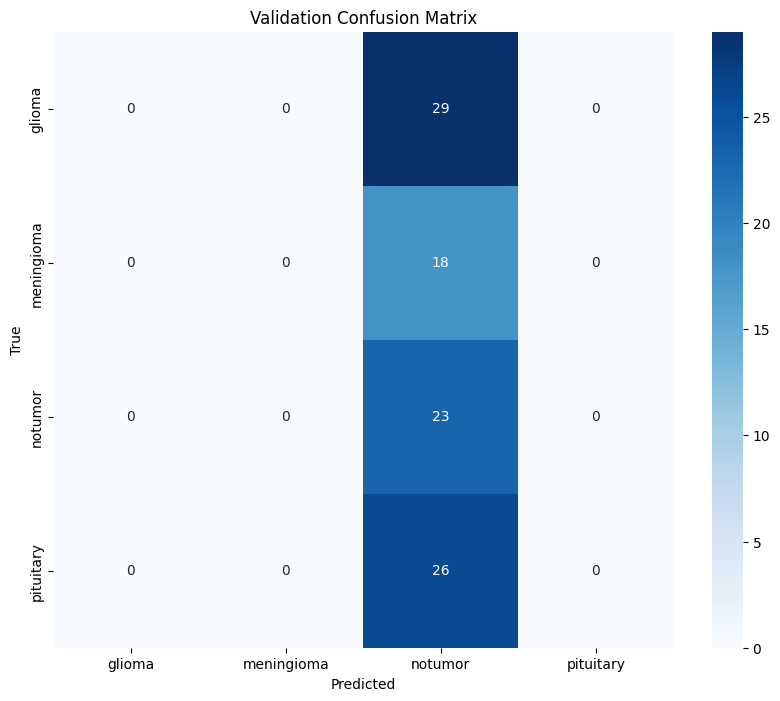

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        29
  meningioma       0.00      0.00      0.00        18
     notumor       0.24      1.00      0.39        23
   pituitary       0.00      0.00      0.00        26

    accuracy                           0.24        96
   macro avg       0.06      0.25      0.10        96
weighted avg       0.06      0.24      0.09        96

AUC-ROC for each class: [0.5, 0.5, 0.5, 0.5]
Class-wise TP, TN, FP, FN:
Class: glioma, TP: 0, TN: 67, FP: 0, FN: 29
Class: meningioma, TP: 0, TN: 78, FP: 0, FN: 18
Class: notumor, TP: 23, TN: 0, FP: 73, FN: 0
Class: pituitary, TP: 0, TN: 70, FP: 0, FN: 26
Val Loss: 1.3866, Val Accuracy: 23.96%
AUC-ROC for Fold 0: [0.5, 0.5, 0.5, 0.5]
Training and evaluation for fold 0 completed.

Starting training for fold 1...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Batch shape: (16, 224, 224, 3)
Labels shape: (16, 4)


Epoch 1/10
24/24 [==============================] - 14s 510ms/step - loss: 1.8514 - accuracy: 0.3932 - val_loss: 1.3843 - val_accuracy: 0.2604
Epoch 2/10
24/24 [==============================] - 12s 489ms/step - loss: 1.0651 - accuracy: 0.5677 - val_loss: 1.3830 - val_accuracy: 0.2708
Epoch 3/10
24/24 [==============================] - 12s 494ms/step - loss: 0.8692 - accuracy: 0.6406 - val_loss: 1.3906 - val_accuracy: 0.2708
Epoch 4/10
24/24 [==============================] - 12s 510ms/step - loss: 0.8116 - accuracy: 0.6797 - val_loss: 1.3952 - val_accuracy: 0.2708
Epoch 5/10
24/24 [==============================] - 12s 493ms/step - loss: 0.7891 - accuracy: 0.6562 - val_loss: 1.3917 - val_accuracy: 0.2708
Evaluating model for fold 1...
6/6 [==============================] - 1s 87ms/step


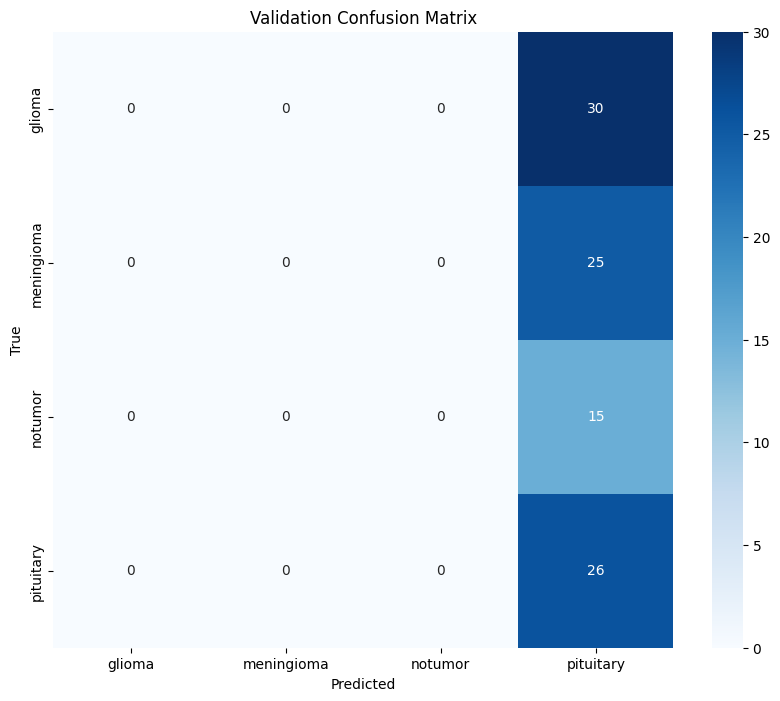

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        30
  meningioma       0.00      0.00      0.00        25
     notumor       0.00      0.00      0.00        15
   pituitary       0.27      1.00      0.43        26

    accuracy                           0.27        96
   macro avg       0.07      0.25      0.11        96
weighted avg       0.07      0.27      0.12        96

AUC-ROC for each class: [0.5, 0.5, 0.5, 0.5]
Class-wise TP, TN, FP, FN:
Class: glioma, TP: 0, TN: 66, FP: 0, FN: 30
Class: meningioma, TP: 0, TN: 71, FP: 0, FN: 25
Class: notumor, TP: 0, TN: 81, FP: 0, FN: 15
Class: pituitary, TP: 26, TN: 0, FP: 70, FN: 0
Val Loss: 1.3830, Val Accuracy: 27.08%
AUC-ROC for Fold 1: [0.5, 0.5, 0.5, 0.5]
Training and evaluation for fold 1 completed.

Starting training for fold 2...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Batch shape: (16, 224, 224, 3)
Labels shape: (16, 4)


Epoch 1/10
24/24 [==============================] - 14s 518ms/step - loss: 1.6237 - accuracy: 0.3932 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 2/10
24/24 [==============================] - 12s 492ms/step - loss: 1.1441 - accuracy: 0.5911 - val_loss: 1.3898 - val_accuracy: 0.2500
Epoch 3/10
24/24 [==============================] - 12s 495ms/step - loss: 0.9274 - accuracy: 0.6276 - val_loss: 1.3909 - val_accuracy: 0.2500
Epoch 4/10
24/24 [==============================] - 12s 504ms/step - loss: 0.6856 - accuracy: 0.7370 - val_loss: 1.3963 - val_accuracy: 0.2500
Evaluating model for fold 2...
6/6 [==============================] - 1s 88ms/step


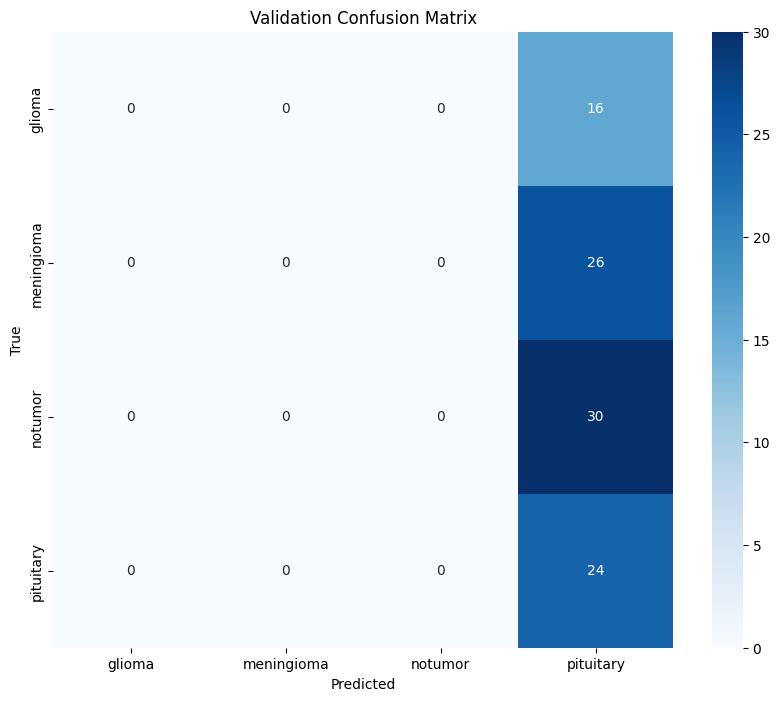

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        16
  meningioma       0.00      0.00      0.00        26
     notumor       0.00      0.00      0.00        30
   pituitary       0.25      1.00      0.40        24

    accuracy                           0.25        96
   macro avg       0.06      0.25      0.10        96
weighted avg       0.06      0.25      0.10        96

AUC-ROC for each class: [0.5, 0.5, 0.5, 0.5]
Class-wise TP, TN, FP, FN:
Class: glioma, TP: 0, TN: 80, FP: 0, FN: 16
Class: meningioma, TP: 0, TN: 70, FP: 0, FN: 26
Class: notumor, TP: 0, TN: 66, FP: 0, FN: 30
Class: pituitary, TP: 24, TN: 0, FP: 72, FN: 0
Val Loss: 1.3863, Val Accuracy: 25.00%
AUC-ROC for Fold 2: [0.5, 0.5, 0.5, 0.5]
Training and evaluation for fold 2 completed.

Starting training for fold 3...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Batch shape: (16, 224, 224, 3)
Labels shape: (

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Epoch 1/10
24/24 [==============================] - 15s 535ms/step - loss: 1.6826 - accuracy: 0.4427 - val_loss: 1.3852 - val_accuracy: 0.2917
Epoch 2/10
24/24 [==============================] - 12s 492ms/step - loss: 0.9889 - accuracy: 0.6042 - val_loss: 1.3869 - val_accuracy: 0.2396
Epoch 3/10
24/24 [==============================] - 12s 494ms/step - loss: 0.8678 - accuracy: 0.6641 - val_loss: 1.3904 - val_accuracy: 0.2396
Epoch 4/10
24/24 [==============================] - 12s 496ms/step - loss: 0.8733 - accuracy: 0.7005 - val_loss: 1.3965 - val_accuracy: 0.2396
Evaluating model for fold 3...
6/6 [==============================] - 1s 89ms/step


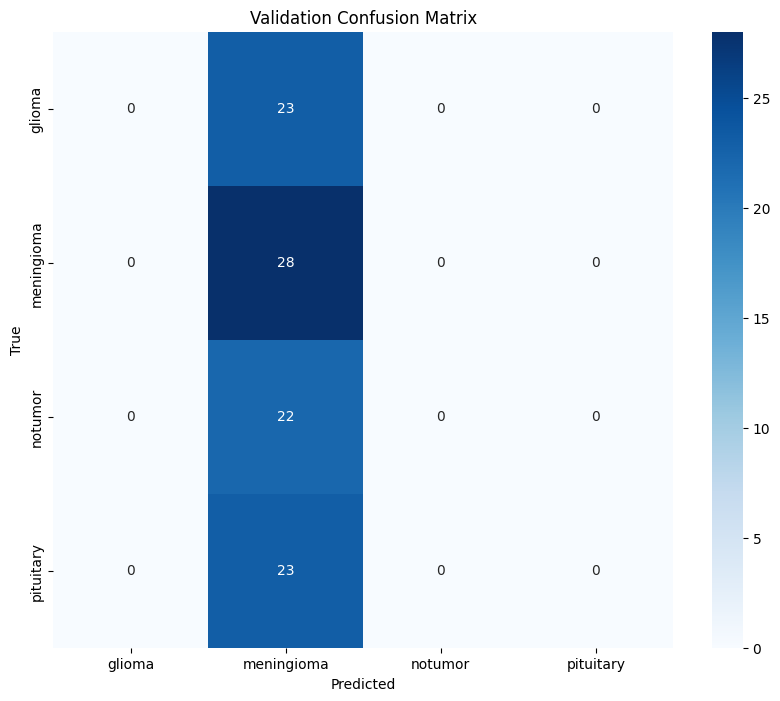

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        23
  meningioma       0.29      1.00      0.45        28
     notumor       0.00      0.00      0.00        22
   pituitary       0.00      0.00      0.00        23

    accuracy                           0.29        96
   macro avg       0.07      0.25      0.11        96
weighted avg       0.09      0.29      0.13        96

AUC-ROC for each class: [0.5, 0.5, 0.5, 0.5]
Class-wise TP, TN, FP, FN:
Class: glioma, TP: 0, TN: 73, FP: 0, FN: 23
Class: meningioma, TP: 28, TN: 0, FP: 68, FN: 0
Class: notumor, TP: 0, TN: 74, FP: 0, FN: 22
Class: pituitary, TP: 0, TN: 73, FP: 0, FN: 23
Val Loss: 1.3852, Val Accuracy: 29.17%
AUC-ROC for Fold 3: [0.5, 0.5, 0.5, 0.5]
Training and evaluation for fold 3 completed.

Starting training for fold 4...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Batch shape: (16, 224, 224, 3)
Labels shape: (16, 4)


Epoch 1/10
24/24 [==============================] - 14s 519ms/step - loss: 1.8622 - accuracy: 0.3958 - val_loss: 1.3882 - val_accuracy: 0.2396
Epoch 2/10
24/24 [==============================] - 53s 976ms/step - loss: 1.0300 - accuracy: 0.5938 - val_loss: 1.3969 - val_accuracy: 0.2292
Epoch 3/10
24/24 [==============================] - 13s 529ms/step - loss: 0.7868 - accuracy: 0.7005 - val_loss: 1.4137 - val_accuracy: 0.2292
Epoch 4/10
24/24 [==============================] - 12s 506ms/step - loss: 0.8017 - accuracy: 0.6901 - val_loss: 1.4325 - val_accuracy: 0.2396
Evaluating model for fold 4...
6/6 [==============================] - 1s 94ms/step


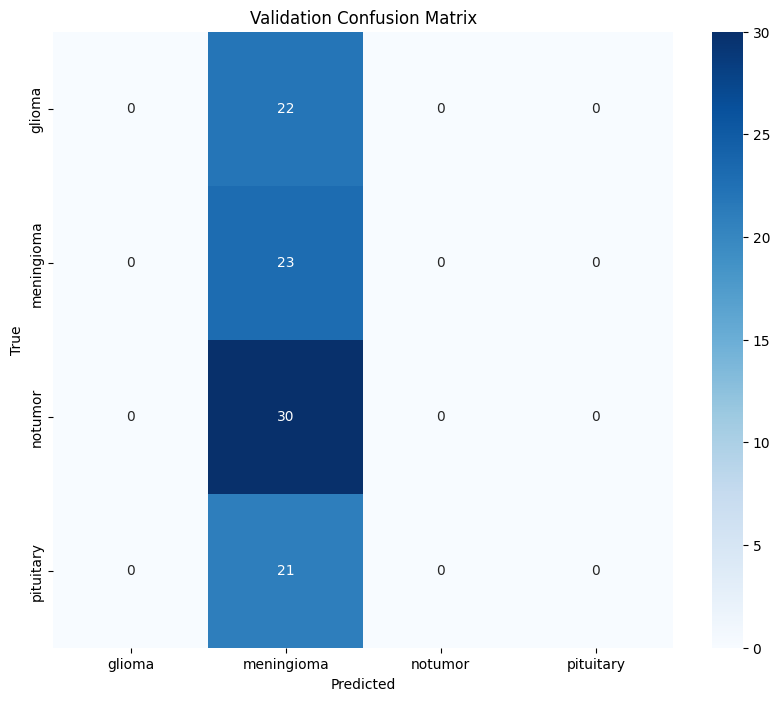

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        22
  meningioma       0.24      1.00      0.39        23
     notumor       0.00      0.00      0.00        30
   pituitary       0.00      0.00      0.00        21

    accuracy                           0.24        96
   macro avg       0.06      0.25      0.10        96
weighted avg       0.06      0.24      0.09        96

AUC-ROC for each class: [0.5, 0.5, 0.4818181818181818, 0.5]
Class-wise TP, TN, FP, FN:
Class: glioma, TP: 0, TN: 74, FP: 0, FN: 22
Class: meningioma, TP: 23, TN: 0, FP: 73, FN: 0
Class: notumor, TP: 0, TN: 66, FP: 0, FN: 30
Class: pituitary, TP: 0, TN: 75, FP: 0, FN: 21
Val Loss: 1.3882, Val Accuracy: 23.96%
AUC-ROC for Fold 4: [0.5, 0.5, 0.4818181818181818, 0.5]
Training and evaluation for fold 4 completed.

Summary of cross-validation results:
Mean validation accuracy: 25.8333%
Standard deviation of validation accuracy: 2.0199%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

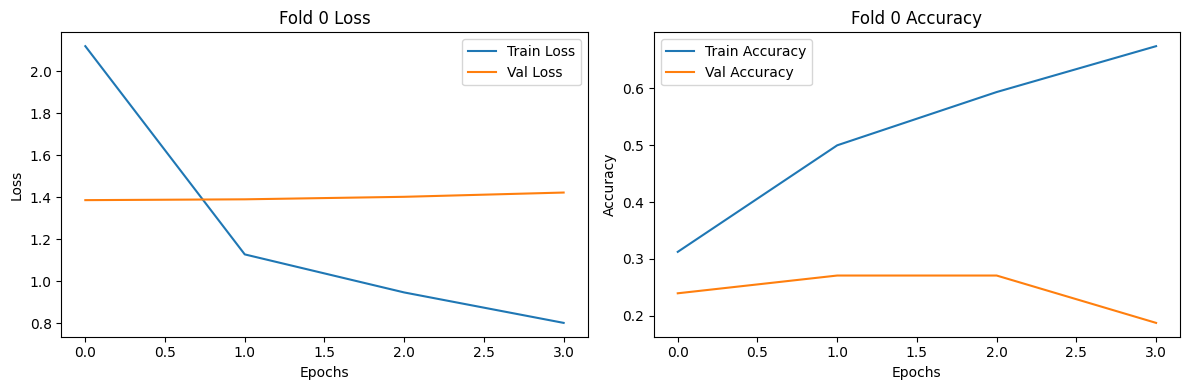

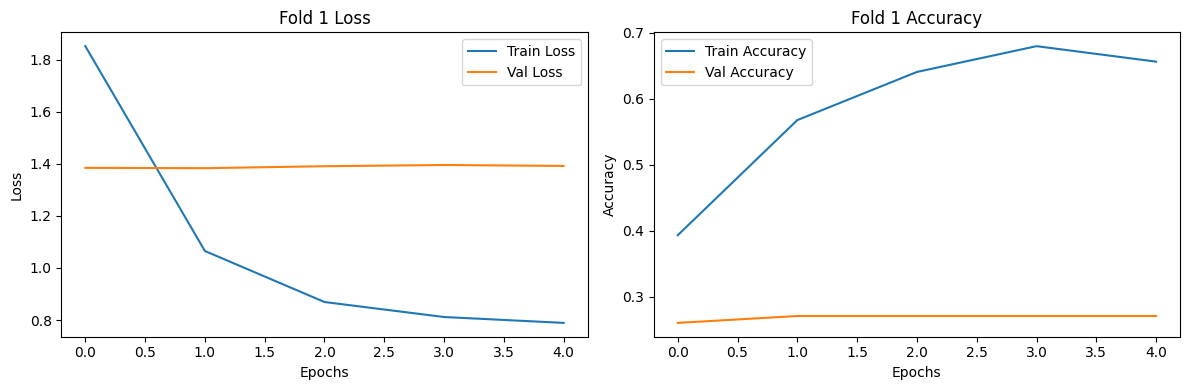

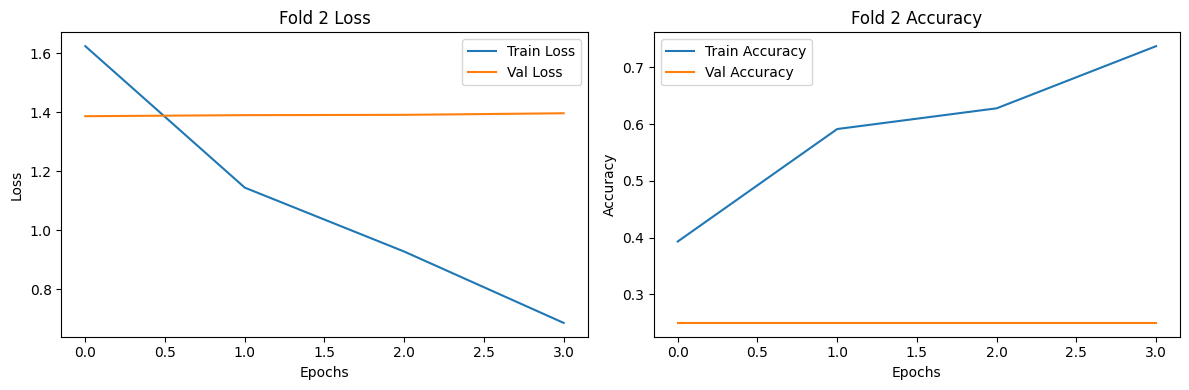

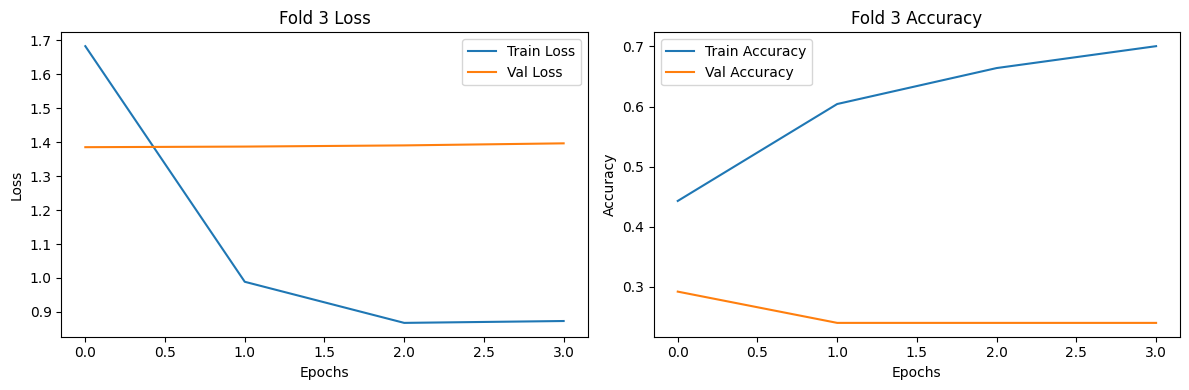

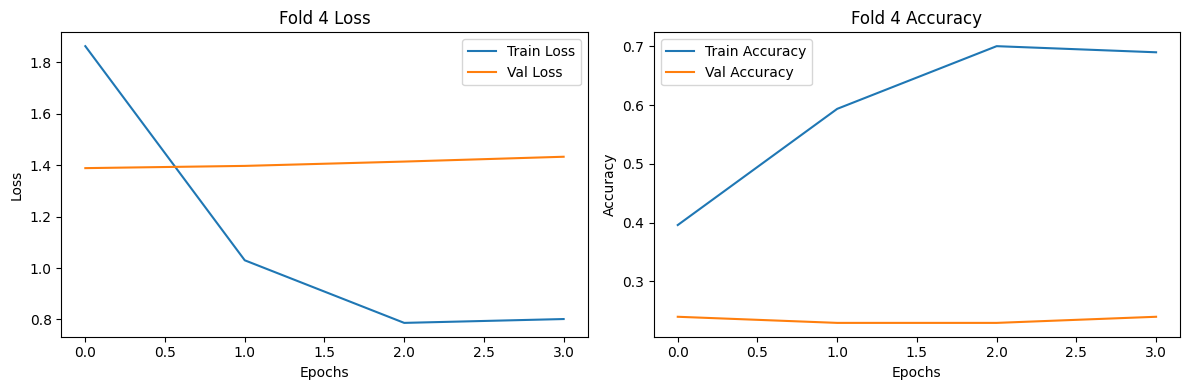

Accuracies for each fold:
Fold 0: 23.96%
Fold 1: 27.08%
Fold 2: 25.00%
Fold 3: 29.17%
Fold 4: 23.96%


In [37]:
# Main Script

base_dir = 'dataset_kfold'
batch_size = 16
num_epochs = 10
learning_rate = 0.001

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
fold_accuracies = []
fold_auc_rocs = []
histories = []

input_shape = (224, 224, 3)
num_classes = 4

# Loop through each fold directory
for fold in range(5):
    print(f'Starting training for fold {fold}...')
    
    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    # Data generators
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        #subset='training'
    )

    val_generator = datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        #subset='validation'
    )

    # Debug: Check data loading
    for data_batch, labels_batch in train_generator:
        print("Batch shape:", data_batch.shape)
        print("Labels shape:", labels_batch.shape)
        break


    # Compute class weights to handle class imbalance
    class_weights = compute_class_weights(train_generator.classes)

    # Get the model
    model = get_mobilenetv2_model(input_shape, num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train and evaluate the model
    model, history = train_model(model, train_generator, val_generator, num_epochs=num_epochs, patience=3)
    
    # Save the model for this fold
    #model_path = f'mobilenetv2_fold_{fold}.h5'
    #model.save(model_path)
    #print(f'Model for fold {fold} saved at {model_path}')

    # Collecting results for plotting
    histories.append(history)
    
    print(f'Evaluating model for fold {fold}...')
    val_loss, val_acc, val_labels, val_preds = evaluate_model(model, val_generator)
    fold_accuracies.append(val_acc)
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc * 100:.2f}%')

    # AUC-ROC Calculation is already computed in evaluate_model and printed

    # Collect fold-wise AUC-ROC scores
    auc_rocs = compute_auc_roc(val_labels, val_preds, num_classes)
    fold_auc_rocs.append(auc_rocs)
    print(f'AUC-ROC for Fold {fold}: {auc_rocs}')

    print(f'Training and evaluation for fold {fold} completed.\n')

# Summary of results across all folds
print('Summary of cross-validation results:')
print(f'Mean validation accuracy: {np.mean(fold_accuracies) * 100:.4f}%')
print(f'Standard deviation of validation accuracy: {np.std(fold_accuracies) * 100:.4f}%')

# Plot the results
plot_results(histories)

# Print the accuracies for each fold
print("Accuracies for each fold:")
for fold, accuracy in enumerate(fold_accuracies):
    print(f"Fold {fold}: {accuracy * 100:.2f}%")

# Own Parameters

## Imports and Setup

In [183]:
# Libraries

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Data Preparation

In [184]:
# Data Preparation

# Load mean and std values from JSON
with open('mean_std.json', 'r') as f:
    mean_std = json.load(f)

mean = mean_std['mean']
std = mean_std['std']

# Data transformations
datagen = ImageDataGenerator(
    rescale=1./255
)

## Model Definition

In [185]:
def get_mobilenetv2_model(input_shape, num_classes):
    #base_model = MobileNetV2(weights=None, include_top=False, input_shape=input_shape)
    weights_path = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
    base_model = MobileNetV2(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(weights_path)
    base_model.trainable = False  # Freeze the base model initially
    
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Add batch normalization
    x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

# Unfreeze the base model after initial epochs
def fine_tune_model(model, train_generator, val_generator, num_epochs=10, patience=3, initial_epochs=5):
    base_model = model.layers[0]  # Assuming the base model is the first layer
    base_model.trainable = True  # Unfreeze the base model
    
    # Recompile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
    
    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr],
        initial_epoch=initial_epochs,
        class_weight=class_weights  # Apply class weights
    )
    
    return model, history

## Training and Validation Functions with Early Stopping

In [186]:
# Training and Validation Functions

def train_model(model, train_generator, val_generator, num_epochs=10, patience=3):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
    
    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights  # Apply class weights
    )
    
    return model, history

## Evaluation Function

In [187]:
def evaluate_model(model, val_generator):
    val_loss, val_accuracy = model.evaluate(val_generator)
    val_preds = model.predict(val_generator)
    val_labels = val_generator.classes
    val_preds_classes = np.argmax(val_preds, axis=1)
    
    # Confusion Matrix
    cm = confusion_matrix(val_labels, val_preds_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(val_generator.class_indices.keys()), yticklabels=list(val_generator.class_indices.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Validation Confusion Matrix')
    plt.show()

    # Classification Report
    report = classification_report(val_labels, val_preds_classes, target_names=list(val_generator.class_indices.keys()))
    print('Classification Report:')
    print(report)

    # AUC-ROC Calculation
    auc_rocs = compute_auc_roc(val_labels, val_preds, len(val_generator.class_indices))
    print(f'AUC-ROC for each class: {auc_rocs}')

    # Calculate TP, TN, FP, FN for each class
    class_names = list(val_generator.class_indices.keys())
    table_data = []
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = np.sum(cm) - tp - fp - fn
        table_data.append([class_name, tp, tn, fp, fn])

    # Print the TP, TN, FP, FN table
    print("Class-wise TP, TN, FP, FN:")
    for row in table_data:
        print(f"Class: {row[0]}, TP: {row[1]}, TN: {row[2]}, FP: {row[3]}, FN: {row[4]}")
    
    return val_loss, val_accuracy, val_labels, val_preds

# AUC-ROC Calculation
def compute_auc_roc(labels, preds, num_classes):
    labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes)
    auc_roc_scores = []
    for i in range(num_classes):
        auc_roc = roc_auc_score(labels_one_hot[:, i], preds[:, i])
        auc_roc_scores.append(auc_roc)
    return auc_roc_scores

# Plot results
def plot_results(histories):
    for fold, history in enumerate(histories):
        plt.figure(figsize=(12, 4))

        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold} Loss')
        plt.legend()

        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Fold {fold} Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [188]:
# Function to compute class weights
def compute_class_weights(labels):
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return dict(enumerate(class_weights))

## Main Script for K-Fold Cross-Validation

Starting training for fold 0...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Batch shape: (64, 224, 224, 3)
Labels shape: (64, 4)


Epoch 1/10
6/6 [==============================] - 7s 801ms/step - loss: 1.9829 - accuracy: 0.2891 - val_loss: 1.3640 - val_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 2/10
6/6 [==============================] - 4s 629ms/step - loss: 1.3655 - accuracy: 0.4818 - val_loss: 1.0686 - val_accuracy: 0.6042 - lr: 1.0000e-04
Epoch 3/10
6/6 [==============================] - 4s 627ms/step - loss: 1.0137 - accuracy: 0.5885 - val_loss: 0.9317 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 4/10
6/6 [==============================] - 4s 616ms/step - loss: 0.8744 - accuracy: 0.6458 - val_loss: 0.8503 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 5/10
6/6 [==============================] - 4s 636ms/step - loss: 0.7507 - accuracy: 0.6901 - val_loss: 0.7768 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 6/10
6/6 [==============================] - 4s 649ms/step - loss: 0.6450 - accuracy: 0.7188 - val_loss: 0.7280 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 7/10
6/6 [==============================] - 4s 621ms

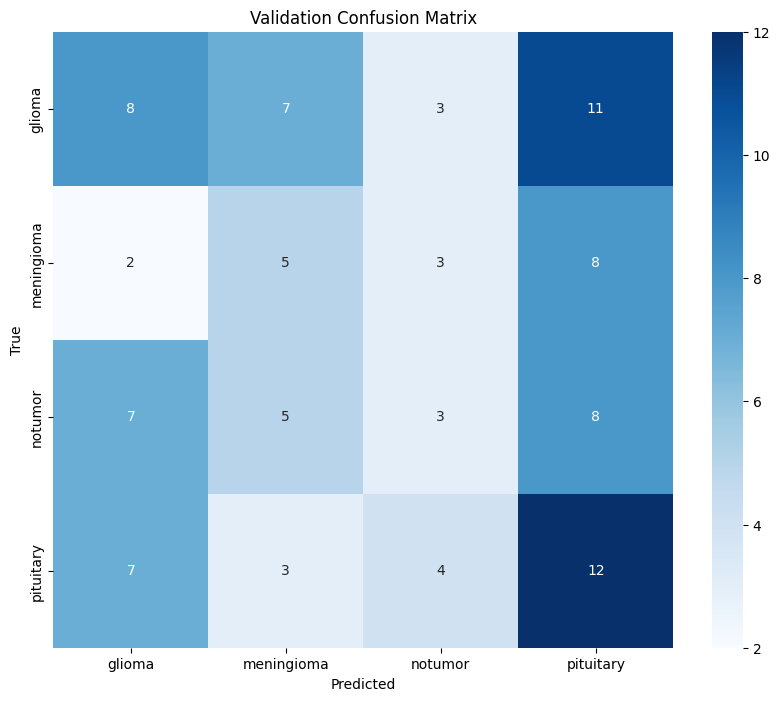

Classification Report:
              precision    recall  f1-score   support

      glioma       0.33      0.28      0.30        29
  meningioma       0.25      0.28      0.26        18
     notumor       0.23      0.13      0.17        23
   pituitary       0.31      0.46      0.37        26

    accuracy                           0.29        96
   macro avg       0.28      0.29      0.28        96
weighted avg       0.29      0.29      0.28        96

AUC-ROC for each class: [0.5169840452907875, 0.5142450142450142, 0.5136986301369864, 0.5538461538461539]
Class-wise TP, TN, FP, FN:
Class: glioma, TP: 8, TN: 51, FP: 16, FN: 21
Class: meningioma, TP: 5, TN: 63, FP: 15, FN: 13
Class: notumor, TP: 3, TN: 63, FP: 10, FN: 20
Class: pituitary, TP: 12, TN: 43, FP: 27, FN: 14
Val Loss: 0.6116, Val Accuracy: 79.17%
AUC-ROC for Fold 0: [0.5169840452907875, 0.5142450142450142, 0.5136986301369864, 0.5538461538461539]
Training and evaluation for fold 0 completed.

Starting training for fold 1...
Fo

Epoch 1/10
6/6 [==============================] - 6s 800ms/step - loss: 2.1033 - accuracy: 0.2786 - val_loss: 1.5605 - val_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 2/10
6/6 [==============================] - 4s 624ms/step - loss: 1.2837 - accuracy: 0.4818 - val_loss: 1.3764 - val_accuracy: 0.4583 - lr: 1.0000e-04
Epoch 3/10
6/6 [==============================] - 4s 628ms/step - loss: 0.9268 - accuracy: 0.6276 - val_loss: 1.2170 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 4/10
6/6 [==============================] - 4s 626ms/step - loss: 0.7937 - accuracy: 0.6901 - val_loss: 1.0678 - val_accuracy: 0.6458 - lr: 1.0000e-04
Epoch 5/10
6/6 [==============================] - 4s 630ms/step - loss: 0.6511 - accuracy: 0.7396 - val_loss: 0.9493 - val_accuracy: 0.6458 - lr: 1.0000e-04
Epoch 6/10
6/6 [==============================] - 4s 630ms/step - loss: 0.5978 - accuracy: 0.7630 - val_loss: 0.8749 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 7/10
6/6 [==============================] - 4s 614ms

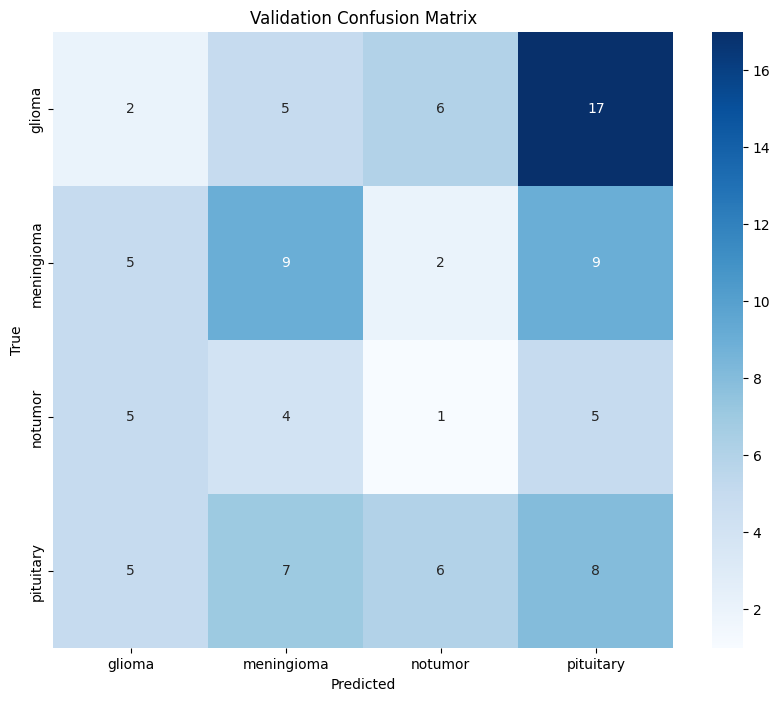

Classification Report:
              precision    recall  f1-score   support

      glioma       0.12      0.07      0.09        30
  meningioma       0.36      0.36      0.36        25
     notumor       0.07      0.07      0.07        15
   pituitary       0.21      0.31      0.25        26

    accuracy                           0.21        96
   macro avg       0.19      0.20      0.19        96
weighted avg       0.20      0.21      0.20        96

AUC-ROC for each class: [0.44267676767676767, 0.5343661971830986, 0.5037037037037038, 0.4714285714285714]
Class-wise TP, TN, FP, FN:
Class: glioma, TP: 2, TN: 51, FP: 15, FN: 28
Class: meningioma, TP: 9, TN: 55, FP: 16, FN: 16
Class: notumor, TP: 1, TN: 67, FP: 14, FN: 14
Class: pituitary, TP: 8, TN: 39, FP: 31, FN: 18
Val Loss: 0.7407, Val Accuracy: 70.83%
AUC-ROC for Fold 1: [0.44267676767676767, 0.5343661971830986, 0.5037037037037038, 0.4714285714285714]
Training and evaluation for fold 1 completed.

Starting training for fold 2...
F

Epoch 1/10
6/6 [==============================] - 6s 858ms/step - loss: 1.5894 - accuracy: 0.3594 - val_loss: 1.4049 - val_accuracy: 0.3229 - lr: 1.0000e-04
Epoch 2/10
6/6 [==============================] - 4s 710ms/step - loss: 1.0619 - accuracy: 0.5573 - val_loss: 1.1834 - val_accuracy: 0.4479 - lr: 1.0000e-04
Epoch 3/10
6/6 [==============================] - 4s 711ms/step - loss: 0.9774 - accuracy: 0.6458 - val_loss: 1.0713 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 4/10
6/6 [==============================] - 4s 718ms/step - loss: 0.8102 - accuracy: 0.6927 - val_loss: 0.9855 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 5/10
6/6 [==============================] - 4s 615ms/step - loss: 0.6344 - accuracy: 0.7812 - val_loss: 0.8989 - val_accuracy: 0.6042 - lr: 1.0000e-04
Epoch 6/10
6/6 [==============================] - 5s 744ms/step - loss: 0.6236 - accuracy: 0.7266 - val_loss: 0.8424 - val_accuracy: 0.6146 - lr: 1.0000e-04
Epoch 7/10
6/6 [==============================] - 5s 737ms

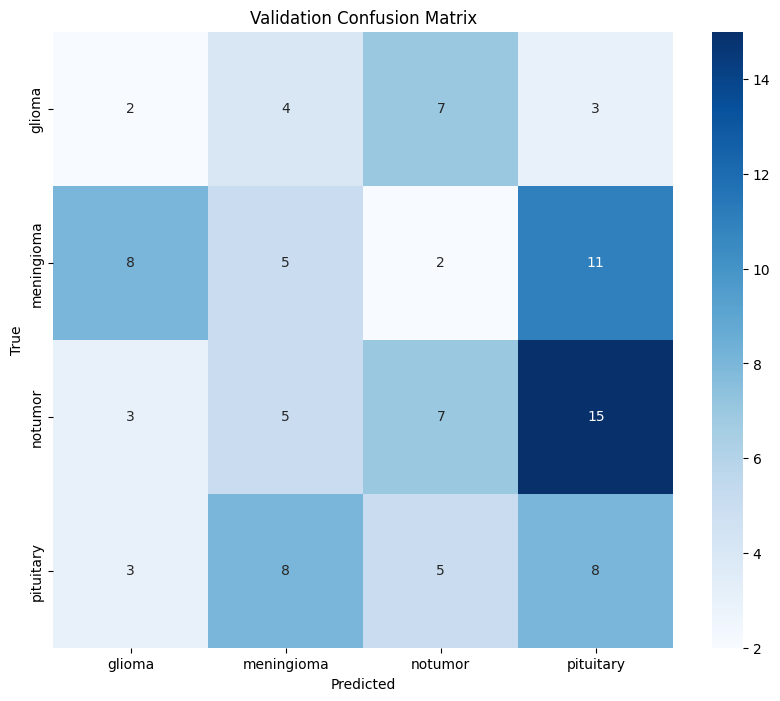

Classification Report:
              precision    recall  f1-score   support

      glioma       0.12      0.12      0.12        16
  meningioma       0.23      0.19      0.21        26
     notumor       0.33      0.23      0.27        30
   pituitary       0.22      0.33      0.26        24

    accuracy                           0.23        96
   macro avg       0.23      0.22      0.22        96
weighted avg       0.24      0.23      0.23        96

AUC-ROC for each class: [0.42968750000000006, 0.5615384615384615, 0.5373737373737373, 0.4461805555555556]
Class-wise TP, TN, FP, FN:
Class: glioma, TP: 2, TN: 66, FP: 14, FN: 14
Class: meningioma, TP: 5, TN: 53, FP: 17, FN: 21
Class: notumor, TP: 7, TN: 52, FP: 14, FN: 23
Class: pituitary, TP: 8, TN: 43, FP: 29, FN: 16
Val Loss: 0.6865, Val Accuracy: 76.04%
AUC-ROC for Fold 2: [0.42968750000000006, 0.5615384615384615, 0.5373737373737373, 0.4461805555555556]
Training and evaluation for fold 2 completed.

Starting training for fold 3...
F

Epoch 1/10
6/6 [==============================] - 6s 807ms/step - loss: 1.8302 - accuracy: 0.3203 - val_loss: 1.2623 - val_accuracy: 0.4062 - lr: 1.0000e-04
Epoch 2/10
6/6 [==============================] - 5s 753ms/step - loss: 1.2091 - accuracy: 0.5156 - val_loss: 0.9523 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 3/10
6/6 [==============================] - 5s 759ms/step - loss: 0.9303 - accuracy: 0.6250 - val_loss: 0.8456 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 4/10
6/6 [==============================] - 4s 692ms/step - loss: 0.7336 - accuracy: 0.7057 - val_loss: 0.8160 - val_accuracy: 0.6354 - lr: 1.0000e-04
Epoch 5/10
6/6 [==============================] - 4s 638ms/step - loss: 0.6568 - accuracy: 0.7578 - val_loss: 0.7917 - val_accuracy: 0.6458 - lr: 1.0000e-04
Epoch 6/10
6/6 [==============================] - 4s 628ms/step - loss: 0.6395 - accuracy: 0.7604 - val_loss: 0.7641 - val_accuracy: 0.6771 - lr: 1.0000e-04
Epoch 7/10
6/6 [==============================] - 4s 645ms

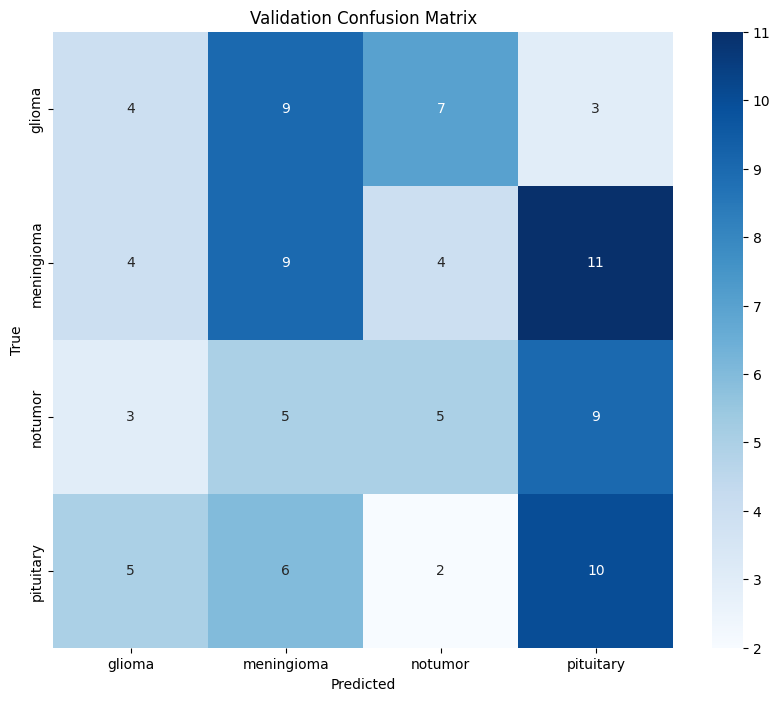

Classification Report:
              precision    recall  f1-score   support

      glioma       0.25      0.17      0.21        23
  meningioma       0.31      0.32      0.32        28
     notumor       0.28      0.23      0.25        22
   pituitary       0.30      0.43      0.36        23

    accuracy                           0.29        96
   macro avg       0.29      0.29      0.28        96
weighted avg       0.29      0.29      0.28        96

AUC-ROC for each class: [0.5074449076831448, 0.4758403361344538, 0.5405405405405406, 0.58487194758785]
Class-wise TP, TN, FP, FN:
Class: glioma, TP: 4, TN: 61, FP: 12, FN: 19
Class: meningioma, TP: 9, TN: 48, FP: 20, FN: 19
Class: notumor, TP: 5, TN: 61, FP: 13, FN: 17
Class: pituitary, TP: 10, TN: 50, FP: 23, FN: 13
Val Loss: 0.6532, Val Accuracy: 72.92%
AUC-ROC for Fold 3: [0.5074449076831448, 0.4758403361344538, 0.5405405405405406, 0.58487194758785]
Training and evaluation for fold 3 completed.

Starting training for fold 4...
Found 

Epoch 1/10
6/6 [==============================] - 7s 863ms/step - loss: 1.7662 - accuracy: 0.3099 - val_loss: 1.3021 - val_accuracy: 0.4167 - lr: 1.0000e-04
Epoch 2/10
6/6 [==============================] - 4s 717ms/step - loss: 1.1045 - accuracy: 0.5312 - val_loss: 1.0985 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 3/10
6/6 [==============================] - 4s 688ms/step - loss: 0.9509 - accuracy: 0.6172 - val_loss: 1.0096 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 4/10
6/6 [==============================] - 5s 840ms/step - loss: 0.7888 - accuracy: 0.6953 - val_loss: 0.9449 - val_accuracy: 0.5521 - lr: 1.0000e-04
Epoch 5/10
6/6 [==============================] - 4s 667ms/step - loss: 0.7102 - accuracy: 0.7266 - val_loss: 0.8825 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 6/10
6/6 [==============================] - 4s 687ms/step - loss: 0.6451 - accuracy: 0.7500 - val_loss: 0.8245 - val_accuracy: 0.6146 - lr: 1.0000e-04
Epoch 7/10
6/6 [==============================] - 4s 711ms

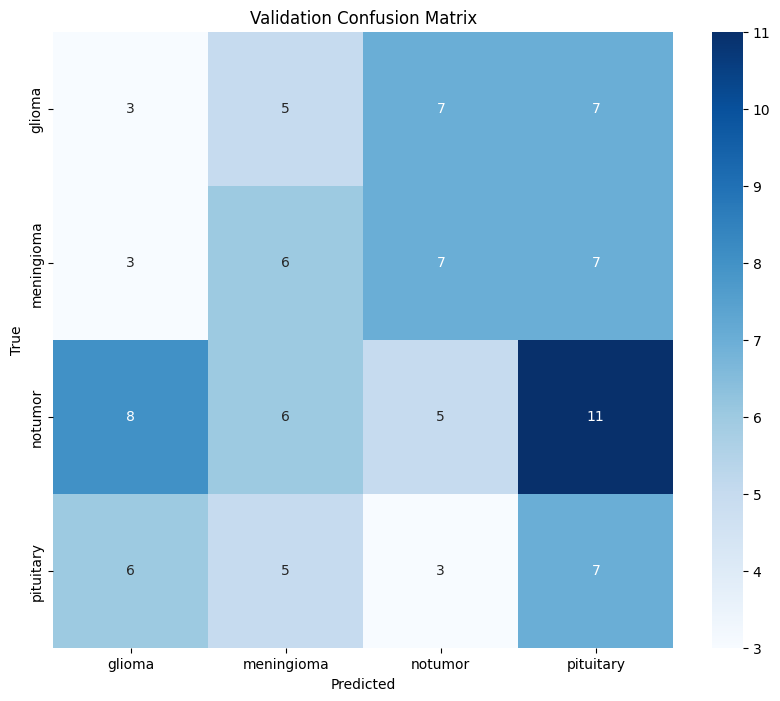

Classification Report:
              precision    recall  f1-score   support

      glioma       0.15      0.14      0.14        22
  meningioma       0.27      0.26      0.27        23
     notumor       0.23      0.17      0.19        30
   pituitary       0.22      0.33      0.26        21

    accuracy                           0.22        96
   macro avg       0.22      0.22      0.22        96
weighted avg       0.22      0.22      0.21        96

AUC-ROC for each class: [0.41400491400491396, 0.4699225729600953, 0.544949494949495, 0.5326984126984127]
Class-wise TP, TN, FP, FN:
Class: glioma, TP: 3, TN: 57, FP: 17, FN: 19
Class: meningioma, TP: 6, TN: 57, FP: 16, FN: 17
Class: notumor, TP: 5, TN: 49, FP: 17, FN: 25
Class: pituitary, TP: 7, TN: 50, FP: 25, FN: 14
Val Loss: 0.6731, Val Accuracy: 70.83%
AUC-ROC for Fold 4: [0.41400491400491396, 0.4699225729600953, 0.544949494949495, 0.5326984126984127]
Training and evaluation for fold 4 completed.

Summary of cross-validation results

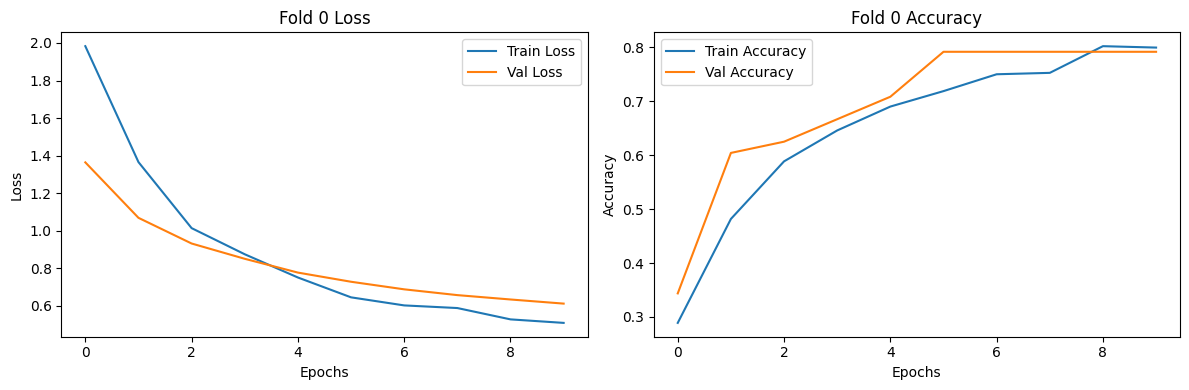

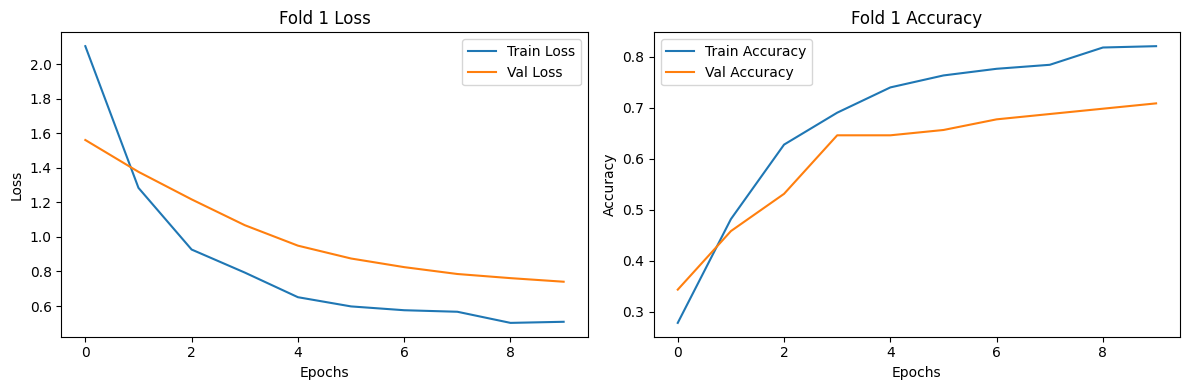

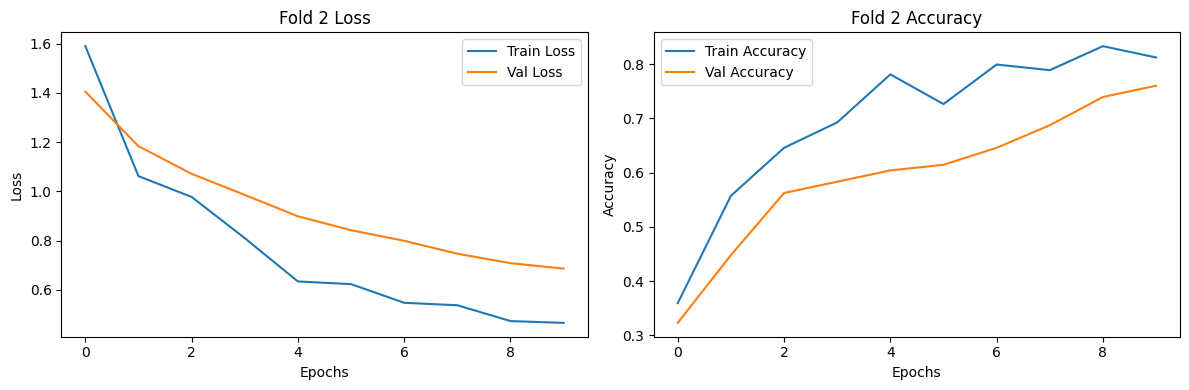

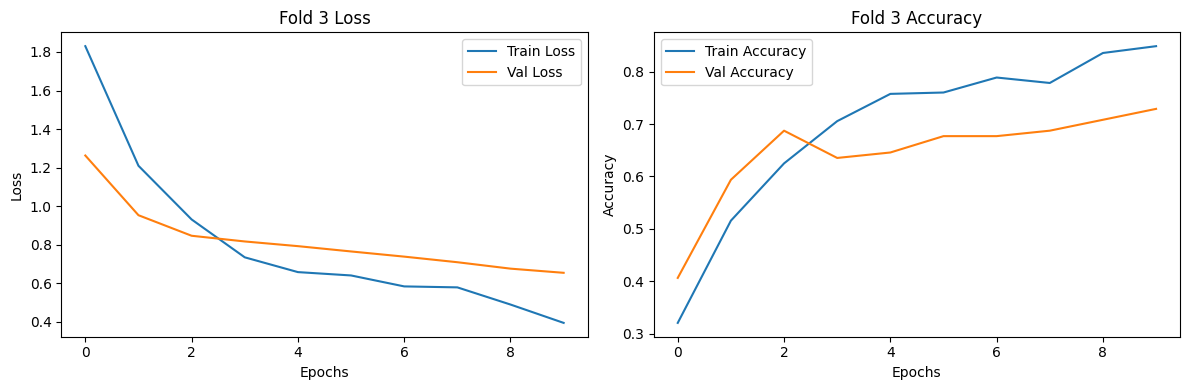

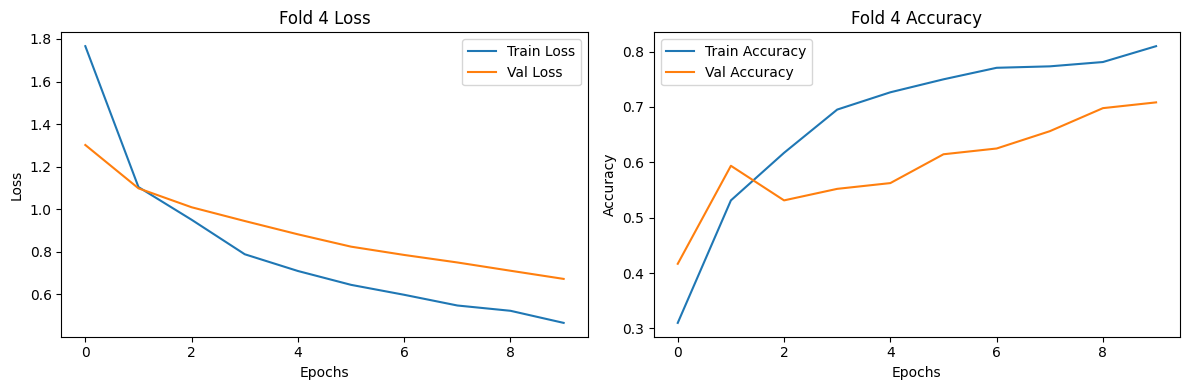

Accuracies for each fold:
Fold 0: 79.17%
Fold 1: 70.83%
Fold 2: 76.04%
Fold 3: 72.92%
Fold 4: 70.83%


In [189]:
# Main Script

base_dir = 'dataset_kfold'
batch_size = 64
num_epochs = 10
learning_rate = 0.0001

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
fold_accuracies = []
fold_auc_rocs = []
histories = []

input_shape = (224, 224, 3)
num_classes = 4

# Loop through each fold directory
for fold in range(5):
    print(f'Starting training for fold {fold}...')
    
    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    # Data generators
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        #subset='training'
    )

    val_generator = datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        #subset='validation'
    )

    # Debug: Check data loading
    for data_batch, labels_batch in train_generator:
        print("Batch shape:", data_batch.shape)
        print("Labels shape:", labels_batch.shape)
        break

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weights(train_generator.classes)

    # Get the model
    model = get_mobilenetv2_model(input_shape, num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train and evaluate the model
    model, history = train_model(model, train_generator, val_generator, num_epochs=num_epochs, patience=3)
    
    # Save the model for this fold
    #model_path = f'mobilenetv2_fold_{fold}.h5'
    #model.save(model_path)
    #print(f'Model for fold {fold} saved at {model_path}')

    # Collecting results for plotting
    histories.append(history)
    
    print(f'Evaluating model for fold {fold}...')
    val_loss, val_acc, val_labels, val_preds = evaluate_model(model, val_generator)
    fold_accuracies.append(val_acc)
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc * 100:.2f}%')

    # AUC-ROC Calculation is already computed in evaluate_model and printed

    # Collect fold-wise AUC-ROC scores
    auc_rocs = compute_auc_roc(val_labels, val_preds, num_classes)
    fold_auc_rocs.append(auc_rocs)
    print(f'AUC-ROC for Fold {fold}: {auc_rocs}')

    print(f'Training and evaluation for fold {fold} completed.\n')

# Summary of results across all folds
print('Summary of cross-validation results:')
print(f'Mean validation accuracy: {np.mean(fold_accuracies) * 100:.4f}%')
print(f'Standard deviation of validation accuracy: {np.std(fold_accuracies) * 100:.4f}%')

# Plot the results
plot_results(histories)

# Print the accuracies for each fold
print("Accuracies for each fold:")
for fold, accuracy in enumerate(fold_accuracies):
    print(f"Fold {fold}: {accuracy * 100:.2f}%")

1/1 [==============================] - 0s 415ms/step


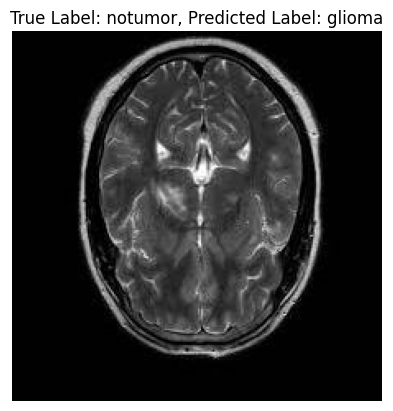

True Label: notumor
Predicted Label: glioma


In [190]:
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image

# Function to predict the class of a single image
def predict_image(image_path, model, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class[0]

# Randomly select an image from the dataset
base_dir = 'dataset_kfold/fold_4/val'  # Update this if needed
class_names = os.listdir(base_dir)
random_class = random.choice(class_names)
random_image = random.choice(os.listdir(os.path.join(base_dir, random_class)))
random_image_path = os.path.join(base_dir, random_class, random_image)

# Predict the class of the random image
predicted_class = predict_image(random_image_path, model, (224, 224))

# Load the image for display
img = Image.open(random_image_path)
plt.imshow(img)
plt.title(f'True Label: {random_class}, Predicted Label: {class_names[predicted_class]}')
plt.axis('off')
plt.show()

# Print true and predicted labels
print(f'True Label: {random_class}')
print(f'Predicted Label: {class_names[predicted_class]}')